In [1]:
from ArticlesRep import MeanSimilarityoneindustry,MeanSimilaritytwoindustry #common function

import pandas as pd

import numpy as np

%matplotlib inline

import pickle

import visdom

from tqdm import tnrange, tqdm_notebook
from tqdm.autonotebook import tqdm
tqdm.pandas()

from time import time,sleep
from datetime import datetime

from sklearn.metrics.pairwise import cosine_similarity
# import visdom
# vis=visdom.Visdom()
# env="TagBased"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# %matplotlib inline

import re
import sys
from pprint import pprint
#coding:utf-8

#solved chinese display in matplotlib
from pylab import mpl
mpl.rcParams["font.family"] = 'DFKai-sb' 
mpl.rcParams['axes.unicode_minus'] = False

list_industry=["水泥","食品飲料","石化","紡織","電機機械","電器電纜","化學工業",
               "建材居家用品","造紙","鋼鐵金屬","車輛相關","科技相關","營建地產","運輸","觀光休閒娛樂",
               "金融相關","百貨通路","公用事業","控股","生技醫療保健","農林漁牧","航天軍工","能源","傳播出版","綜合",
               "傳產其他","其他","金屬礦採選",
              ]
element="氫氦鋰鈹硼碳氮氧氟氖鈉鎂鋁矽磷硫氯氬鉀鈣鈧鈦釩鉻錳鐵鈷鎳銅鋅鎵鍺砷硒溴氪銣鍶銀鎘銦錫銻碲碘氙銫鋇鉑金汞鉈鉛鉍釙氡鍅鐳"

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from keras.layers import Dense,Lambda,Input,Dot,Add,Subtract,GaussianDropout
from keras.utils import Sequence,plot_model
from keras.models import Model,load_model
from keras import backend as K


Using TensorFlow backend.


### Denoising Autoencoder with weak supervision

In [3]:
# custommed function
def noisefunction(x):
    x_noise=K.ones_like(x)
    return K.in_train_phase(x_noise,x,1)

def tripletlossfunction(inputs):
    r01=inputs[0]
    r02=inputs[1]
    loss=K.log(1+K.exp(r02-r01))
#     x=np.array([[0],[1],[0],[1]])
#     x=K.variable(x)
    return loss

def losspassfunction(y_true,y_pred):
    return y_pred

def test(inputs):
#     x=K.dot(inputs,k.transpose(inputs))
    x=K.transpose(inputs)
    return x

In [4]:
x=Input(shape=(5,))
y=Lambda(noisefunction)(x)
model=Model(x,y)
x=np.arange(2*5).reshape((2,5))
model.predict(x)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [31]:
K.clear_session()
np.random.seed(100)
###############
# instantiate layer
# noise=Lambda(noisefunction,name="noisefunction")
# trilosslayer=Lambda(Triplet,name="trilosslayer")
# dense=Dense(units=12000,activation="sigmoid",name="Dense1")
###############
#parameter setting
path="Models/Model1"
BOW_dim=19404
DR_dim=100
loss_weights=[1,1,1,2]

##Encoder
x=Input((BOW_dim,),name="encoder_input")
# y=Lambda(noisefunction,name="noisefunction")
y=GaussianDropout(rate=0.2,name="noise")(x)
# y=Dense(units=2000,activation="sigmoid",name="Dense_1")(y)
y=Dense(units=DR_dim,activation="sigmoid",name="Dense_2",use_bias=False)(y)
encoder=Model(x,y,name="encoder")

##Decoder
x=Input((DR_dim,),name="input") 
y=x
# y=Dense(units=2000,activation="sigmoid",use_bias=False,name="Dense_1")(y)
y=Dense(units=BOW_dim,activation="sigmoid",name="Dense_2")(y)
decoder=Model(x,y,name="decoder")

##Tripletloss
x0=Input((DR_dim,),name="anchor_input")
x1=Input((DR_dim,),name="positive_input")
x2=Input((DR_dim,),name="negative_input")
r01=Dot(axes=1,name="SimiPositive")([x0,x1])
r02=Dot(axes=1,name="SimiNegative")([x0,x2])
out=Lambda(tripletlossfunction,name="tripletlossfunction")([r01,r02])
tripletloss=Model(inputs=[x0,x1,x2],outputs=out,name="triplet")

#Build Tri-Autoencoder model
x0=Input((BOW_dim,),name="anchor_input")
x1=Input((BOW_dim,),name="positive_input")
x2=Input((BOW_dim,),name="negative_input")

h0=encoder(x0)
h1=encoder(x1)
h2=encoder(x2)

Lt=tripletloss([h0,h1,h2])

y0=decoder(h0)
y1=decoder(h1)
y2=decoder(h2)

y0=Lambda(lambda x :x ,name="anchor")(y0)
y1=Lambda(lambda x :x ,name="positive")(y1)
y2=Lambda(lambda x :x ,name="negative")(y2)

# triplet_loss

Tri_AutoEncoder=Model(inputs=[x0,x1,x2],outputs=[y0,y1,y2,Lt])
Tri_AutoEncoder.compile(optimizer="adam",
                        loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy',losspassfunction],
                        loss_weights=loss_weights
                       )
#save initial model
Tri_AutoEncoder.save("{}/Tri_AutoEncoder.initial.h5".format(path))
# encoder.save("encoder.initial.h5")
# decoder.save("decoder.initial.h5")
#plot
plot_model(Tri_AutoEncoder,to_file="{}/Tri_DenoiseAutoEncoder.png".format(path))
plot_model(encoder,to_file="{}/encoder.png".format(path))
plot_model(decoder,to_file="{}/decoder.png".format(path))
# Open the file to record
with open('{}/Tri_AutoEencoderncoder.summary.txt'.format(path),'w') as f:
    # Pass the file handle in as a lambda function to make it callable
    Tri_AutoEncoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('{}/encoder.summary.txt'.format(path),'w') as f:
    # Pass the file handle in as a lambda function to make it callable
    encoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('{}/decoder.summary.txt'.format(path),'w') as f:
    # Pass the file handle in as a lambda function to make it callable
    decoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))

Tri_AutoEncoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 19404)        0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 19404)        0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 19404)        0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 100)          1940400     anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

## Load Data

In [9]:
Data=np.load("D:3.AutoencoderForArticle/BOW_binary_v02.npy")

In [10]:
with open("D:3.AutoencoderForArticle/train_dict_collect_small_industry","rb") as f:
    train_dict_collect_small_industry=pickle.load(f)

In [11]:
with open("D:3.AutoencoderForArticle/test_dict_collect_small_industry","rb") as f:
    test_dict_collect_small_industry=pickle.load(f)

## Data generator

In [32]:
class DataGenerator(Sequence):

    def __init__(self, tripletindex,Data, batch_size=32):
        self.tripletindex= np.asarray(tripletindex)
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        self.batch_size = batch_size
        self.Data=Data

    def __len__(self):
         return int(np.ceil(self.tripletindex.shape[0] / float(self.batch_size)))
#         return 1
    def __getitem__(self, idx):
        batch_index = self.tripletindex[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_anchor = self.Data[batch_index[:,0]]
        batch_positive = self.Data[batch_index[:,1]]
        batch_negative = self.Data[batch_index[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        

In [33]:
class HardTriGenerator(Sequence):

    def __init__(self, dict_id_news,Data, P=3,K=3):
        self.dict_id_news=dict_id_news
        self.industry=np.asarray(list(dict_id_news.keys()))
#         pick=np.random.permutation(len(self.tripletindex))
#         self.tripletindex= self.tripletindex[pick]
        self.P=P
        self.K=K
        self.Data=Data

    def __len__(self):
        return int(np.ceil(len(self.industry) / self.P))
#         return 1
    def __getitem__(self, idx):
        indusrty= self.industry[idx*self.P:(idx+1)*self.P]
        small_dict_id_news={i:np.random.choice(self.dict_id_news[i],size=self.K,replace=False) for i in indusrty}
        dict_small_triplet=dict()
        for k in small_dict_id_news:
            poslist=small_dict_id_news[k]
            poslen=len(poslist)
            neglist=[]
            for j in small_dict_id_news:
                if k!=j:neglist+=list(small_dict_id_news[j])
                neglen=len(neglist)
            indarray=np.zeros((int(poslen*(poslen-1)*neglen),3),dtype=int)
            i=0
            for ip1_,a in enumerate(poslist):
                for ip2_,p in enumerate(poslist):
                    if ip1_!=ip2_:
                        for in_,n in enumerate(neglist):
        #                   print(p1,p2,n)
                            indarray[i,0]=a
                            indarray[i,1]=p
                            indarray[i,2]=n
                            i+=1
        #                 break
        #             break
        #         break
            dict_small_triplet[k]=indarray            
        for i,k in enumerate(dict_small_triplet):
            if i==0:tripletindex=dict_small_triplet[k]
            else:tripletindex=np.concatenate((tripletindex,dict_small_triplet[k]),axis=0)   
        batch_anchor=self.Data[tripletindex[:,0]]
        batch_positive=self.Data[tripletindex[:,1]]
        batch_negative=self.Data[tripletindex[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))    
        
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        self.industry=np.random.permutation(self.industry)       

In [34]:
#setup

#instantiate generator
traingenerator=HardTriGenerator(dict_id_news=train_dict_collect_small_industry,
                                Data=Data,
                                P=3,
                                K=8,
                               )
testgenerator=HardTriGenerator(dict_id_news=test_dict_collect_small_industry,
                               Data=Data,P=3,K=8,
                              )

In [35]:
for _,i in enumerate(traingenerator):
    print(i[0][2].shape)
    break

(2688, 19404)


## Callback function

In [41]:
from keras.callbacks import TerminateOnNaN,ModelCheckpoint,TensorBoard
checkpointer = ModelCheckpoint(filepath='{}/bestmodel.hdf5'.format(path), verbose=0, save_best_only=True,period=10)
regularsave = ModelCheckpoint(filepath="{}".format(path)+'/regular/weights.{epoch:02d}.hdf5',
                              save_weights_only=True, 
                              verbose=0,
                              save_best_only=False,period=50)
logname="model"
tensorboard=TensorBoard(log_dir="./logs/{}".format(logname))

## Train

In [42]:
#initial
Tri_AutoEncoder=load_model("{}/Tri_AutoEncoder.initial.h5".format(path),custom_objects={"losspassfunction":losspassfunction})
#setup
epochs=1000
# steps_per_epoch=5
#train
History=Tri_AutoEncoder.fit_generator(callbacks=[checkpointer,tensorboard,regularsave],
                                      generator=traingenerator,
#                                       shuffle=True,
                                      epochs=epochs,
#                                       steps_per_epoch=steps_per_epoch,
                                      validation_data=testgenerator,
                                      verbose=2,
                                      workers=1,use_multiprocessing=False,
                                      
                                    
                                     )
#save model
Tri_AutoEncoder.save("{}/Tri_AutoEncoder_trained.h5".format(path))
Tri_AutoEncoder.save_weights("{}/weights.h5".format(path))

Epoch 1/1000
 - 11s - loss: 3.4343 - anchor_loss: 0.6799 - positive_loss: 0.6799 - negative_loss: 0.6799 - triplet_loss: 0.6974 - val_loss: 3.3455 - val_anchor_loss: 0.6471 - val_positive_loss: 0.6471 - val_negative_loss: 0.6471 - val_triplet_loss: 0.7021
Epoch 2/1000
 - 11s - loss: 3.3200 - anchor_loss: 0.6338 - positive_loss: 0.6338 - negative_loss: 0.6338 - triplet_loss: 0.7093 - val_loss: 3.2035 - val_anchor_loss: 0.6022 - val_positive_loss: 0.6022 - val_negative_loss: 0.6022 - val_triplet_loss: 0.6984
Epoch 3/1000
 - 11s - loss: 3.2298 - anchor_loss: 0.5933 - positive_loss: 0.5933 - negative_loss: 0.5933 - triplet_loss: 0.7249 - val_loss: 3.0673 - val_anchor_loss: 0.5609 - val_positive_loss: 0.5609 - val_negative_loss: 0.5609 - val_triplet_loss: 0.6924
Epoch 4/1000
 - 11s - loss: 3.1912 - anchor_loss: 0.5490 - positive_loss: 0.5490 - negative_loss: 0.5490 - triplet_loss: 0.7721 - val_loss: 2.9949 - val_anchor_loss: 0.5215 - val_positive_loss: 0.5215 - val_negative_loss: 0.5215 - v

Epoch 33/1000
 - 11s - loss: 1.7467 - anchor_loss: 0.1032 - positive_loss: 0.1032 - negative_loss: 0.1032 - triplet_loss: 0.7185 - val_loss: 1.5070 - val_anchor_loss: 0.1030 - val_positive_loss: 0.1030 - val_negative_loss: 0.1030 - val_triplet_loss: 0.5989
Epoch 34/1000
 - 11s - loss: 1.9348 - anchor_loss: 0.1006 - positive_loss: 0.1006 - negative_loss: 0.1006 - triplet_loss: 0.8165 - val_loss: 1.4378 - val_anchor_loss: 0.0963 - val_positive_loss: 0.0963 - val_negative_loss: 0.0963 - val_triplet_loss: 0.5745
Epoch 35/1000
 - 11s - loss: 1.6981 - anchor_loss: 0.0986 - positive_loss: 0.0985 - negative_loss: 0.0986 - triplet_loss: 0.7012 - val_loss: 1.3438 - val_anchor_loss: 0.0938 - val_positive_loss: 0.0938 - val_negative_loss: 0.0938 - val_triplet_loss: 0.5312
Epoch 36/1000
 - 11s - loss: 1.8200 - anchor_loss: 0.0941 - positive_loss: 0.0941 - negative_loss: 0.0941 - triplet_loss: 0.7689 - val_loss: 1.3940 - val_anchor_loss: 0.0920 - val_positive_loss: 0.0920 - val_negative_loss: 0.0920

Epoch 65/1000
 - 11s - loss: 1.2670 - anchor_loss: 0.0574 - positive_loss: 0.0574 - negative_loss: 0.0574 - triplet_loss: 0.5473 - val_loss: 0.9885 - val_anchor_loss: 0.0539 - val_positive_loss: 0.0539 - val_negative_loss: 0.0539 - val_triplet_loss: 0.4134
Epoch 66/1000
 - 11s - loss: 0.9671 - anchor_loss: 0.0577 - positive_loss: 0.0577 - negative_loss: 0.0577 - triplet_loss: 0.3970 - val_loss: 0.9191 - val_anchor_loss: 0.0557 - val_positive_loss: 0.0557 - val_negative_loss: 0.0557 - val_triplet_loss: 0.3759
Epoch 67/1000
 - 11s - loss: 1.0349 - anchor_loss: 0.0536 - positive_loss: 0.0536 - negative_loss: 0.0536 - triplet_loss: 0.4370 - val_loss: 0.8859 - val_anchor_loss: 0.0538 - val_positive_loss: 0.0538 - val_negative_loss: 0.0538 - val_triplet_loss: 0.3622
Epoch 68/1000
 - 11s - loss: 0.8666 - anchor_loss: 0.0529 - positive_loss: 0.0528 - negative_loss: 0.0528 - triplet_loss: 0.3541 - val_loss: 0.8433 - val_anchor_loss: 0.0528 - val_positive_loss: 0.0528 - val_negative_loss: 0.0528

Epoch 97/1000
 - 11s - loss: 0.4504 - anchor_loss: 0.0375 - positive_loss: 0.0375 - negative_loss: 0.0375 - triplet_loss: 0.1689 - val_loss: 0.6430 - val_anchor_loss: 0.0381 - val_positive_loss: 0.0381 - val_negative_loss: 0.0381 - val_triplet_loss: 0.2643
Epoch 98/1000
 - 11s - loss: 0.6008 - anchor_loss: 0.0380 - positive_loss: 0.0380 - negative_loss: 0.0380 - triplet_loss: 0.2434 - val_loss: 0.5498 - val_anchor_loss: 0.0376 - val_positive_loss: 0.0376 - val_negative_loss: 0.0376 - val_triplet_loss: 0.2185
Epoch 99/1000
 - 11s - loss: 0.6675 - anchor_loss: 0.0361 - positive_loss: 0.0361 - negative_loss: 0.0361 - triplet_loss: 0.2796 - val_loss: 0.6580 - val_anchor_loss: 0.0352 - val_positive_loss: 0.0352 - val_negative_loss: 0.0352 - val_triplet_loss: 0.2763
Epoch 100/1000
 - 11s - loss: 0.9587 - anchor_loss: 0.0375 - positive_loss: 0.0375 - negative_loss: 0.0375 - triplet_loss: 0.4231 - val_loss: 0.4841 - val_anchor_loss: 0.0379 - val_positive_loss: 0.0379 - val_negative_loss: 0.037

Epoch 129/1000
 - 11s - loss: 0.4251 - anchor_loss: 0.0315 - positive_loss: 0.0315 - negative_loss: 0.0315 - triplet_loss: 0.1653 - val_loss: 0.4158 - val_anchor_loss: 0.0328 - val_positive_loss: 0.0328 - val_negative_loss: 0.0328 - val_triplet_loss: 0.1587
Epoch 130/1000
 - 11s - loss: 0.3810 - anchor_loss: 0.0298 - positive_loss: 0.0298 - negative_loss: 0.0298 - triplet_loss: 0.1458 - val_loss: 0.5074 - val_anchor_loss: 0.0333 - val_positive_loss: 0.0333 - val_negative_loss: 0.0333 - val_triplet_loss: 0.2037
Epoch 131/1000
 - 11s - loss: 0.3689 - anchor_loss: 0.0326 - positive_loss: 0.0326 - negative_loss: 0.0326 - triplet_loss: 0.1355 - val_loss: 0.7787 - val_anchor_loss: 0.0330 - val_positive_loss: 0.0330 - val_negative_loss: 0.0330 - val_triplet_loss: 0.3398
Epoch 132/1000
 - 11s - loss: 0.3773 - anchor_loss: 0.0303 - positive_loss: 0.0303 - negative_loss: 0.0303 - triplet_loss: 0.1432 - val_loss: 0.7638 - val_anchor_loss: 0.0339 - val_positive_loss: 0.0339 - val_negative_loss: 0.

Epoch 161/1000
 - 11s - loss: 0.4256 - anchor_loss: 0.0269 - positive_loss: 0.0269 - negative_loss: 0.0269 - triplet_loss: 0.1724 - val_loss: 0.6316 - val_anchor_loss: 0.0302 - val_positive_loss: 0.0302 - val_negative_loss: 0.0302 - val_triplet_loss: 0.2705
Epoch 162/1000
 - 11s - loss: 0.3073 - anchor_loss: 0.0287 - positive_loss: 0.0287 - negative_loss: 0.0287 - triplet_loss: 0.1106 - val_loss: 0.6931 - val_anchor_loss: 0.0304 - val_positive_loss: 0.0304 - val_negative_loss: 0.0304 - val_triplet_loss: 0.3010
Epoch 163/1000
 - 11s - loss: 0.3089 - anchor_loss: 0.0281 - positive_loss: 0.0281 - negative_loss: 0.0281 - triplet_loss: 0.1122 - val_loss: 0.7074 - val_anchor_loss: 0.0291 - val_positive_loss: 0.0291 - val_negative_loss: 0.0291 - val_triplet_loss: 0.3100
Epoch 164/1000
 - 11s - loss: 0.3086 - anchor_loss: 0.0293 - positive_loss: 0.0293 - negative_loss: 0.0293 - triplet_loss: 0.1103 - val_loss: 0.4959 - val_anchor_loss: 0.0268 - val_positive_loss: 0.0268 - val_negative_loss: 0.

Epoch 193/1000
 - 11s - loss: 0.3228 - anchor_loss: 0.0256 - positive_loss: 0.0256 - negative_loss: 0.0256 - triplet_loss: 0.1230 - val_loss: 0.4844 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0225 - val_negative_loss: 0.0225 - val_triplet_loss: 0.2085
Epoch 194/1000
 - 11s - loss: 0.2916 - anchor_loss: 0.0248 - positive_loss: 0.0248 - negative_loss: 0.0248 - triplet_loss: 0.1086 - val_loss: 0.2509 - val_anchor_loss: 0.0249 - val_positive_loss: 0.0249 - val_negative_loss: 0.0249 - val_triplet_loss: 0.0881
Epoch 195/1000
 - 11s - loss: 0.2703 - anchor_loss: 0.0242 - positive_loss: 0.0242 - negative_loss: 0.0242 - triplet_loss: 0.0988 - val_loss: 0.3904 - val_anchor_loss: 0.0265 - val_positive_loss: 0.0265 - val_negative_loss: 0.0265 - val_triplet_loss: 0.1554
Epoch 196/1000
 - 11s - loss: 0.1658 - anchor_loss: 0.0258 - positive_loss: 0.0258 - negative_loss: 0.0258 - triplet_loss: 0.0442 - val_loss: 0.3186 - val_anchor_loss: 0.0246 - val_positive_loss: 0.0246 - val_negative_loss: 0.

Epoch 225/1000
 - 11s - loss: 0.1214 - anchor_loss: 0.0269 - positive_loss: 0.0269 - negative_loss: 0.0269 - triplet_loss: 0.0203 - val_loss: 0.2454 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0236 - val_negative_loss: 0.0236 - val_triplet_loss: 0.0873
Epoch 226/1000
 - 11s - loss: 0.2042 - anchor_loss: 0.0241 - positive_loss: 0.0241 - negative_loss: 0.0241 - triplet_loss: 0.0659 - val_loss: 0.5893 - val_anchor_loss: 0.0248 - val_positive_loss: 0.0248 - val_negative_loss: 0.0248 - val_triplet_loss: 0.2575
Epoch 227/1000
 - 11s - loss: 0.1680 - anchor_loss: 0.0257 - positive_loss: 0.0257 - negative_loss: 0.0257 - triplet_loss: 0.0454 - val_loss: 0.5368 - val_anchor_loss: 0.0251 - val_positive_loss: 0.0251 - val_negative_loss: 0.0251 - val_triplet_loss: 0.2308
Epoch 228/1000
 - 11s - loss: 0.1912 - anchor_loss: 0.0253 - positive_loss: 0.0253 - negative_loss: 0.0253 - triplet_loss: 0.0576 - val_loss: 0.2575 - val_anchor_loss: 0.0257 - val_positive_loss: 0.0257 - val_negative_loss: 0.

Epoch 257/1000
 - 11s - loss: 0.1217 - anchor_loss: 0.0243 - positive_loss: 0.0243 - negative_loss: 0.0243 - triplet_loss: 0.0243 - val_loss: 0.1854 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.0604
Epoch 258/1000
 - 11s - loss: 0.1700 - anchor_loss: 0.0218 - positive_loss: 0.0218 - negative_loss: 0.0218 - triplet_loss: 0.0522 - val_loss: 0.2604 - val_anchor_loss: 0.0258 - val_positive_loss: 0.0258 - val_negative_loss: 0.0258 - val_triplet_loss: 0.0915
Epoch 259/1000
 - 11s - loss: 0.1191 - anchor_loss: 0.0257 - positive_loss: 0.0257 - negative_loss: 0.0257 - triplet_loss: 0.0211 - val_loss: 0.3466 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0223 - val_negative_loss: 0.0223 - val_triplet_loss: 0.1398
Epoch 260/1000
 - 11s - loss: 0.0924 - anchor_loss: 0.0244 - positive_loss: 0.0244 - negative_loss: 0.0244 - triplet_loss: 0.0096 - val_loss: 0.2378 - val_anchor_loss: 0.0235 - val_positive_loss: 0.0235 - val_negative_loss: 0.

Epoch 289/1000
 - 11s - loss: 0.1684 - anchor_loss: 0.0218 - positive_loss: 0.0218 - negative_loss: 0.0218 - triplet_loss: 0.0514 - val_loss: 0.3987 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.0221 - val_triplet_loss: 0.1662
Epoch 290/1000
 - 11s - loss: 0.0954 - anchor_loss: 0.0234 - positive_loss: 0.0234 - negative_loss: 0.0234 - triplet_loss: 0.0126 - val_loss: 0.4600 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.2004
Epoch 291/1000
 - 11s - loss: 0.1180 - anchor_loss: 0.0238 - positive_loss: 0.0238 - negative_loss: 0.0238 - triplet_loss: 0.0233 - val_loss: 0.4241 - val_anchor_loss: 0.0232 - val_positive_loss: 0.0232 - val_negative_loss: 0.0232 - val_triplet_loss: 0.1773
Epoch 292/1000
 - 11s - loss: 0.1517 - anchor_loss: 0.0254 - positive_loss: 0.0254 - negative_loss: 0.0254 - triplet_loss: 0.0378 - val_loss: 0.3589 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0233 - val_negative_loss: 0.

Epoch 321/1000
 - 11s - loss: 0.2364 - anchor_loss: 0.0230 - positive_loss: 0.0230 - negative_loss: 0.0230 - triplet_loss: 0.0837 - val_loss: 0.2324 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.0858
Epoch 322/1000
 - 11s - loss: 0.0898 - anchor_loss: 0.0230 - positive_loss: 0.0230 - negative_loss: 0.0230 - triplet_loss: 0.0104 - val_loss: 0.3554 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1465
Epoch 323/1000
 - 11s - loss: 0.0836 - anchor_loss: 0.0235 - positive_loss: 0.0235 - negative_loss: 0.0235 - triplet_loss: 0.0066 - val_loss: 0.2832 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.1089
Epoch 324/1000
 - 11s - loss: 0.1097 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0238 - val_loss: 0.3739 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.

Epoch 353/1000
 - 11s - loss: 0.1178 - anchor_loss: 0.0221 - positive_loss: 0.0221 - negative_loss: 0.0221 - triplet_loss: 0.0257 - val_loss: 0.2620 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss: 0.0219 - val_triplet_loss: 0.0982
Epoch 354/1000
 - 11s - loss: 0.0988 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 0.0169 - val_loss: 0.3986 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.1670
Epoch 355/1000
 - 11s - loss: 0.1122 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.0249 - val_loss: 0.3376 - val_anchor_loss: 0.0237 - val_positive_loss: 0.0237 - val_negative_loss: 0.0237 - val_triplet_loss: 0.1333
Epoch 356/1000
 - 11s - loss: 0.0893 - anchor_loss: 0.0223 - positive_loss: 0.0223 - negative_loss: 0.0223 - triplet_loss: 0.0111 - val_loss: 0.3775 - val_anchor_loss: 0.0244 - val_positive_loss: 0.0244 - val_negative_loss: 0.

Epoch 385/1000
 - 11s - loss: 0.1486 - anchor_loss: 0.0224 - positive_loss: 0.0224 - negative_loss: 0.0224 - triplet_loss: 0.0407 - val_loss: 0.1668 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.0522
Epoch 386/1000
 - 11s - loss: 0.0944 - anchor_loss: 0.0219 - positive_loss: 0.0219 - negative_loss: 0.0219 - triplet_loss: 0.0143 - val_loss: 0.3833 - val_anchor_loss: 0.0235 - val_positive_loss: 0.0235 - val_negative_loss: 0.0235 - val_triplet_loss: 0.1564
Epoch 387/1000
 - 11s - loss: 0.0877 - anchor_loss: 0.0210 - positive_loss: 0.0210 - negative_loss: 0.0210 - triplet_loss: 0.0124 - val_loss: 0.1751 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0579
Epoch 388/1000
 - 11s - loss: 0.0948 - anchor_loss: 0.0219 - positive_loss: 0.0219 - negative_loss: 0.0219 - triplet_loss: 0.0146 - val_loss: 0.2396 - val_anchor_loss: 0.0255 - val_positive_loss: 0.0255 - val_negative_loss: 0.

Epoch 417/1000
 - 11s - loss: 0.1111 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0253 - val_loss: 0.2114 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.0770
Epoch 418/1000
 - 11s - loss: 0.1038 - anchor_loss: 0.0219 - positive_loss: 0.0219 - negative_loss: 0.0219 - triplet_loss: 0.0191 - val_loss: 0.5401 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.0221 - val_triplet_loss: 0.2369
Epoch 419/1000
 - 11s - loss: 0.1067 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.0222 - val_loss: 0.3328 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0188 - val_negative_loss: 0.0188 - val_triplet_loss: 0.1381
Epoch 420/1000
 - 11s - loss: 0.0865 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0145 - val_loss: 0.4606 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negative_loss: 0.

Epoch 449/1000
 - 11s - loss: 0.1030 - anchor_loss: 0.0212 - positive_loss: 0.0212 - negative_loss: 0.0212 - triplet_loss: 0.0196 - val_loss: 0.2412 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0229 - val_negative_loss: 0.0229 - val_triplet_loss: 0.0863
Epoch 450/1000
 - 11s - loss: 0.0893 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0139 - val_loss: 0.5147 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss: 0.0195 - val_triplet_loss: 0.2281
Epoch 451/1000
 - 11s - loss: 0.1075 - anchor_loss: 0.0214 - positive_loss: 0.0214 - negative_loss: 0.0214 - triplet_loss: 0.0216 - val_loss: 0.2375 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.0875
Epoch 452/1000
 - 11s - loss: 0.0695 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0028 - val_loss: 0.1985 - val_anchor_loss: 0.0186 - val_positive_loss: 0.0186 - val_negative_loss: 0.

Epoch 481/1000
 - 11s - loss: 0.0818 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0100 - val_loss: 0.1362 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.0360
Epoch 482/1000
 - 11s - loss: 0.0864 - anchor_loss: 0.0227 - positive_loss: 0.0227 - negative_loss: 0.0227 - triplet_loss: 0.0091 - val_loss: 0.1527 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.0436
Epoch 483/1000
 - 11s - loss: 0.0758 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.0067 - val_loss: 0.2157 - val_anchor_loss: 0.0180 - val_positive_loss: 0.0180 - val_negative_loss: 0.0180 - val_triplet_loss: 0.0808
Epoch 484/1000
 - 11s - loss: 0.0768 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0076 - val_loss: 0.5171 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.

Epoch 513/1000
 - 11s - loss: 0.0712 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0053 - val_loss: 0.1925 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.0672
Epoch 514/1000
 - 11s - loss: 0.0714 - anchor_loss: 0.0219 - positive_loss: 0.0218 - negative_loss: 0.0219 - triplet_loss: 0.0029 - val_loss: 0.2267 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0227 - val_negative_loss: 0.0227 - val_triplet_loss: 0.0793
Epoch 515/1000
 - 11s - loss: 0.0895 - anchor_loss: 0.0224 - positive_loss: 0.0224 - negative_loss: 0.0224 - triplet_loss: 0.0111 - val_loss: 0.2413 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negative_loss: 0.0181 - val_triplet_loss: 0.0935
Epoch 516/1000
 - 11s - loss: 0.0793 - anchor_loss: 0.0214 - positive_loss: 0.0214 - negative_loss: 0.0214 - triplet_loss: 0.0076 - val_loss: 0.2558 - val_anchor_loss: 0.0184 - val_positive_loss: 0.0184 - val_negative_loss: 0.

Epoch 545/1000
 - 11s - loss: 0.0890 - anchor_loss: 0.0231 - positive_loss: 0.0231 - negative_loss: 0.0231 - triplet_loss: 0.0099 - val_loss: 0.4495 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.1923
Epoch 546/1000
 - 11s - loss: 0.0712 - anchor_loss: 0.0198 - positive_loss: 0.0198 - negative_loss: 0.0198 - triplet_loss: 0.0060 - val_loss: 0.2692 - val_anchor_loss: 0.0173 - val_positive_loss: 0.0173 - val_negative_loss: 0.0173 - val_triplet_loss: 0.1087
Epoch 547/1000
 - 11s - loss: 0.0867 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 0.0111 - val_loss: 0.1427 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.0406
Epoch 548/1000
 - 11s - loss: 0.0720 - anchor_loss: 0.0228 - positive_loss: 0.0228 - negative_loss: 0.0228 - triplet_loss: 0.0018 - val_loss: 0.2699 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negative_loss: 0.

Epoch 577/1000
 - 11s - loss: 0.0807 - anchor_loss: 0.0214 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 0.0082 - val_loss: 0.1737 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negative_loss: 0.0181 - val_triplet_loss: 0.0596
Epoch 578/1000
 - 11s - loss: 0.0991 - anchor_loss: 0.0220 - positive_loss: 0.0220 - negative_loss: 0.0220 - triplet_loss: 0.0165 - val_loss: 0.1232 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.0295
Epoch 579/1000
 - 11s - loss: 0.0785 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0102 - val_loss: 0.2811 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0185 - val_negative_loss: 0.0185 - val_triplet_loss: 0.1128
Epoch 580/1000
 - 11s - loss: 0.0667 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0046 - val_loss: 0.3304 - val_anchor_loss: 0.0156 - val_positive_loss: 0.0156 - val_negative_loss: 0.

Epoch 609/1000
 - 11s - loss: 0.0736 - anchor_loss: 0.0224 - positive_loss: 0.0224 - negative_loss: 0.0224 - triplet_loss: 0.0033 - val_loss: 0.6190 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0227 - val_negative_loss: 0.0227 - val_triplet_loss: 0.2754
Epoch 610/1000
 - 11s - loss: 0.0643 - anchor_loss: 0.0193 - positive_loss: 0.0193 - negative_loss: 0.0193 - triplet_loss: 0.0032 - val_loss: 0.4409 - val_anchor_loss: 0.0176 - val_positive_loss: 0.0176 - val_negative_loss: 0.0176 - val_triplet_loss: 0.1941
Epoch 611/1000
 - 11s - loss: 0.0882 - anchor_loss: 0.0203 - positive_loss: 0.0203 - negative_loss: 0.0203 - triplet_loss: 0.0136 - val_loss: 0.1393 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0182 - val_negative_loss: 0.0182 - val_triplet_loss: 0.0423
Epoch 612/1000
 - 11s - loss: 0.0684 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 0.0020 - val_loss: 0.1822 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.

Epoch 641/1000
 - 11s - loss: 0.0752 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 0.0053 - val_loss: 0.3073 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.0222 - val_triplet_loss: 0.1203
Epoch 642/1000
 - 11s - loss: 0.0761 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0082 - val_loss: 0.1386 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0398
Epoch 643/1000
 - 11s - loss: 0.0767 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0081 - val_loss: 0.3466 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.1434
Epoch 644/1000
 - 11s - loss: 0.0749 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0067 - val_loss: 0.1598 - val_anchor_loss: 0.0239 - val_positive_loss: 0.0239 - val_negative_loss: 0.

Epoch 673/1000
 - 11s - loss: 0.0613 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0038 - val_loss: 0.1933 - val_anchor_loss: 0.0171 - val_positive_loss: 0.0171 - val_negative_loss: 0.0171 - val_triplet_loss: 0.0710
Epoch 674/1000
 - 11s - loss: 0.0728 - anchor_loss: 0.0184 - positive_loss: 0.0184 - negative_loss: 0.0184 - triplet_loss: 0.0088 - val_loss: 0.3511 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negative_loss: 0.0181 - val_triplet_loss: 0.1485
Epoch 675/1000
 - 11s - loss: 0.0693 - anchor_loss: 0.0209 - positive_loss: 0.0209 - negative_loss: 0.0209 - triplet_loss: 0.0033 - val_loss: 0.2408 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negative_loss: 0.0181 - val_triplet_loss: 0.0933
Epoch 676/1000
 - 11s - loss: 0.0725 - anchor_loss: 0.0180 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 0.0092 - val_loss: 0.1661 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.

Epoch 705/1000
 - 11s - loss: 0.0725 - anchor_loss: 0.0229 - positive_loss: 0.0229 - negative_loss: 0.0229 - triplet_loss: 0.0019 - val_loss: 0.2740 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0236 - val_negative_loss: 0.0236 - val_triplet_loss: 0.1017
Epoch 706/1000
 - 11s - loss: 0.0589 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0013 - val_loss: 0.5508 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.2451
Epoch 707/1000
 - 11s - loss: 0.0709 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0054 - val_loss: 0.2329 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.0840
Epoch 708/1000
 - 11s - loss: 0.0760 - anchor_loss: 0.0221 - positive_loss: 0.0221 - negative_loss: 0.0221 - triplet_loss: 0.0049 - val_loss: 0.4979 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.

Epoch 737/1000
 - 11s - loss: 0.0661 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0023 - val_loss: 0.2141 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.0758
Epoch 738/1000
 - 11s - loss: 0.0692 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0026 - val_loss: 0.2499 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.0958
Epoch 739/1000
 - 11s - loss: 0.0694 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0027 - val_loss: 0.2299 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.0830
Epoch 740/1000
 - 11s - loss: 0.0708 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0046 - val_loss: 0.2990 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.

Epoch 769/1000
 - 11s - loss: 0.0689 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0049 - val_loss: 0.3452 - val_anchor_loss: 0.0177 - val_positive_loss: 0.0177 - val_negative_loss: 0.0177 - val_triplet_loss: 0.1461
Epoch 770/1000
 - 11s - loss: 0.0652 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0023 - val_loss: 0.6309 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.2851
Epoch 771/1000
 - 11s - loss: 0.0625 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0042 - val_loss: 0.1848 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negative_loss: 0.0181 - val_triplet_loss: 0.0653
Epoch 772/1000
 - 11s - loss: 0.0738 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0058 - val_loss: 0.3009 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.

Epoch 801/1000
 - 11s - loss: 0.0610 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0023 - val_loss: 0.1552 - val_anchor_loss: 0.0171 - val_positive_loss: 0.0171 - val_negative_loss: 0.0171 - val_triplet_loss: 0.0519
Epoch 802/1000
 - 10s - loss: 0.0661 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 5.9570e-04 - val_loss: 0.2924 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0225 - val_negative_loss: 0.0225 - val_triplet_loss: 0.1125
Epoch 803/1000
 - 11s - loss: 0.0657 - anchor_loss: 0.0206 - positive_loss: 0.0207 - negative_loss: 0.0206 - triplet_loss: 0.0019 - val_loss: 0.3207 - val_anchor_loss: 0.0170 - val_positive_loss: 0.0170 - val_negative_loss: 0.0170 - val_triplet_loss: 0.1348
Epoch 804/1000
 - 11s - loss: 0.0702 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0070 - val_loss: 0.2581 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0228 - val_negative_loss

Epoch 833/1000
 - 11s - loss: 0.0631 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0027 - val_loss: 0.1597 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.0478
Epoch 834/1000
 - 10s - loss: 0.0688 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0060 - val_loss: 0.1909 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.0644
Epoch 835/1000
 - 11s - loss: 0.0570 - anchor_loss: 0.0175 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0022 - val_loss: 0.3168 - val_anchor_loss: 0.0172 - val_positive_loss: 0.0172 - val_negative_loss: 0.0172 - val_triplet_loss: 0.1327
Epoch 836/1000
 - 11s - loss: 0.0644 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0026 - val_loss: 0.3946 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.

Epoch 865/1000
 - 11s - loss: 0.0623 - anchor_loss: 0.0161 - positive_loss: 0.0161 - negative_loss: 0.0161 - triplet_loss: 0.0070 - val_loss: 0.1314 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.0350
Epoch 866/1000
 - 11s - loss: 0.0576 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0172 - triplet_loss: 0.0029 - val_loss: 0.3438 - val_anchor_loss: 0.0173 - val_positive_loss: 0.0173 - val_negative_loss: 0.0173 - val_triplet_loss: 0.1459
Epoch 867/1000
 - 11s - loss: 0.0749 - anchor_loss: 0.0235 - positive_loss: 0.0235 - negative_loss: 0.0235 - triplet_loss: 0.0022 - val_loss: 0.2202 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.0798
Epoch 868/1000
 - 11s - loss: 0.0700 - anchor_loss: 0.0211 - positive_loss: 0.0211 - negative_loss: 0.0211 - triplet_loss: 0.0033 - val_loss: 0.3556 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.

Epoch 897/1000
 - 11s - loss: 0.0667 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0049 - val_loss: 0.4020 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0225 - val_negative_loss: 0.0225 - val_triplet_loss: 0.1673
Epoch 898/1000
 - 11s - loss: 0.0588 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0028 - val_loss: 0.2588 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0999
Epoch 899/1000
 - 11s - loss: 0.0586 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0019 - val_loss: 0.1418 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.0378
Epoch 900/1000
 - 11s - loss: 0.0600 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0034 - val_loss: 0.2970 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.

Epoch 929/1000
 - 11s - loss: 0.0654 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0042 - val_loss: 0.2110 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.0738
Epoch 930/1000
 - 11s - loss: 0.0632 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0036 - val_loss: 0.1715 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.0533
Epoch 931/1000
 - 11s - loss: 0.0651 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0019 - val_loss: 0.4478 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0223 - val_negative_loss: 0.0223 - val_triplet_loss: 0.1905
Epoch 932/1000
 - 11s - loss: 0.0610 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0019 - val_loss: 0.1674 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.

Epoch 961/1000
 - 11s - loss: 0.0611 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0013 - val_loss: 0.3463 - val_anchor_loss: 0.0167 - val_positive_loss: 0.0167 - val_negative_loss: 0.0167 - val_triplet_loss: 0.1481
Epoch 962/1000
 - 11s - loss: 0.0687 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0035 - val_loss: 0.1705 - val_anchor_loss: 0.0178 - val_positive_loss: 0.0178 - val_negative_loss: 0.0178 - val_triplet_loss: 0.0585
Epoch 963/1000
 - 11s - loss: 0.0656 - anchor_loss: 0.0214 - positive_loss: 0.0214 - negative_loss: 0.0214 - triplet_loss: 7.0538e-04 - val_loss: 0.1176 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negative_loss: 0.0187 - val_triplet_loss: 0.0307
Epoch 964/1000
 - 11s - loss: 0.0579 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0032 - val_loss: 0.2681 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss

Epoch 993/1000
 - 11s - loss: 0.0622 - anchor_loss: 0.0196 - positive_loss: 0.0196 - negative_loss: 0.0196 - triplet_loss: 0.0016 - val_loss: 0.1287 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0185 - val_negative_loss: 0.0185 - val_triplet_loss: 0.0366
Epoch 994/1000
 - 11s - loss: 0.0621 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0029 - val_loss: 0.1954 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0182 - val_negative_loss: 0.0182 - val_triplet_loss: 0.0703
Epoch 995/1000
 - 11s - loss: 0.0637 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0032 - val_loss: 0.0872 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.0148
Epoch 996/1000
 - 11s - loss: 0.0605 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0023 - val_loss: 0.2546 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.

In [ ]:
# #partial fit
# Tri_AutoEncoder=load_model("Tri_AutoEncoder.initial.h5",custom_objects={"losspassfunction":losspassfunction})
# epoch=1
# for i in range(epoch):
#     for i in traingenerator:
#         Tri_AutoEncoder.train_on_batch(x=i[0],y=i[1])

In [45]:
df=pd.DataFrame(History.history)
df.to_hdf("{}/history.h5".format(path),key="data")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002402E702BE0>,
      dtype=object)

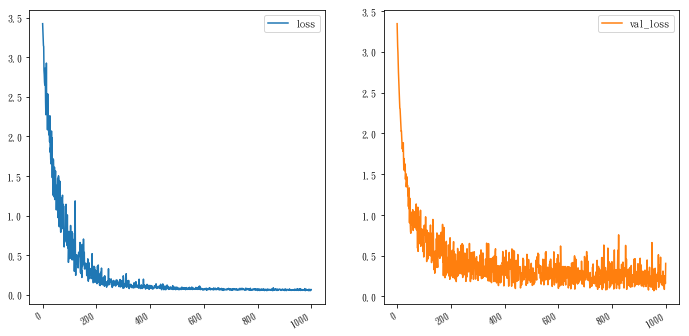

In [46]:
df[["loss","val_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002403C9C6128>,
      dtype=object)

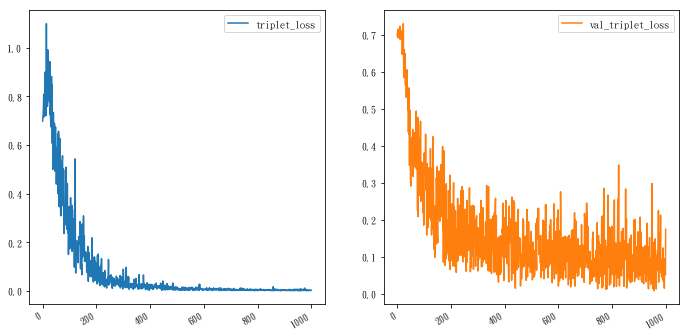

In [47]:
df[["triplet_loss","val_triplet_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024195F308D0>,
      dtype=object)

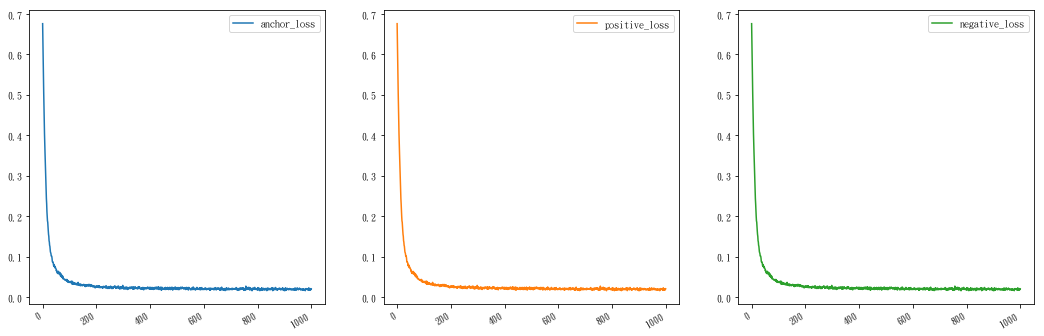

In [48]:
df[["anchor_loss","positive_loss","negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002417E2A15C0>,
      dtype=object)

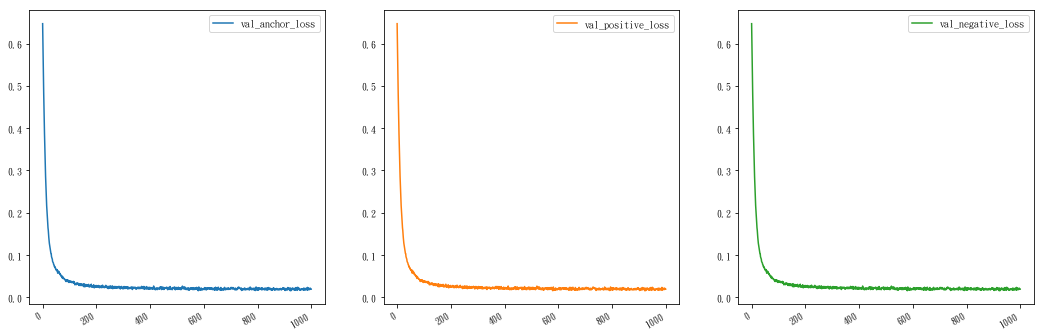

In [49]:
df[["val_anchor_loss","val_positive_loss","val_negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))